# SETTING UP THE ENVIRONMENT

In [38]:
import os
import os.path as path
import traceback as tb
import cv2
import numpy as np




import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from joblib import Parallel, delayed
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment as lsa
from random import choice as pick
from tqdm import tqdm
import shutil
from collections import Counter
import itertools

from sklearn import cluster as clustering
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import silhouette_score as ss
from sklearn.preprocessing import StandardScaler as sscale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


In [6]:
training_dir = r"C:\Users\Quentin\Documents\Savoir\Sciences\Informatiques\IA\Machine_Learning\Image & Video Processing\TP2\STL10\stl10_raw\train"
testing_dir = r"C:\Users\Quentin\Documents\Savoir\Sciences\Informatiques\IA\Machine_Learning\Image & Video Processing\TP2\STL10\stl10_raw\test"

# 1.3 Feature Description with Histograms of Oriented Gradients (HOG)

In [3]:
def load_image(img_path: str, to_gray: bool = True):
    try:
        # Load image in grayscale or color mode
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if to_gray else cv2.IMREAD_COLOR)
    except Exception as err:
        print(tb.format_exc())
        print(f'Error loading image: {err}')
    
    if img is None:
        raise ValueError(f"Image not found at: {img_path}")
    
    return img

def show_image(img_data: np.ndarray, img_title: str = None):
    # Display the image using Plotly
    figure = px.imshow(img_data)
    figure.update_layout(title=img_title, coloraxis_showscale=False)
    figure.show()


In [7]:
def fetch_image_dimensions_by_category(root_dir: str) -> dict[str, tuple[int, int]]:

    categories = os.listdir(root_dir)
    dimensions_per_category = {}
    
    for cat in categories:
        cat_path = os.path.join(root_dir, cat)
        if not os.path.exists(cat_path):
            raise ValueError(f"Category folder not found: {cat_path}")
        # List all valid image files in the category
        img_files = [file for file in os.listdir(cat_path) if file.endswith((".png", ".jpg", ".img"))]
        
        if not img_files:
            raise ValueError(f"No valid image files found in {root_dir}")
        
        # Read the first image to get its dimensions
        first_img = load_image(os.path.join(cat_path, img_files[0]))
        dimensions_per_category[cat] = first_img.shape[:2]
    
    return dimensions_per_category


#Ensuring that all images within each category share the same shape
fetch_image_dimensions_by_category(training_dir)


{'airplane': (96, 96),
 'bird': (96, 96),
 'car': (96, 96),
 'cat': (96, 96),
 'deer': (96, 96),
 'dog': (96, 96),
 'horse': (96, 96),
 'monkey': (96, 96),
 'ship': (96, 96),
 'truck': (96, 96)}

In [18]:
def pick_random_image(root_dir: str, category: str) -> str:
    # Construct the category path
    cat_path = os.path.join(root_dir, category)
    
    if not os.path.exists(cat_path):
        raise ValueError(f"Category folder not found: {cat_path}")
    
    # List valid image files in the category
    img_files = [file for file in os.listdir(cat_path) if file.endswith((".png", ".jpg", ".img"))]
    
    if not img_files:
        raise ValueError(f"No image files found in {root_dir}")
    
    # Select a random image
    rand_img = pick(img_files)
    
    return os.path.join(cat_path, "airplane_train_298.png") # We change to a specific image of fighter plane  by desire


# Testing the function with a random image from the "airplane" category
test_img_path = pick_random_image(training_dir, "airplane")
show_image(load_image(test_img_path))


In [19]:
def create_dense_grid(x_points: int, y_points: int, img: np.ndarray, verbose=True) -> tuple[np.ndarray, np.ndarray]:

    img_height, img_width = img.shape[:2]
    if verbose:
        print(f"Image dimensions: {img_height}x{img_width}")
    # Generate evenly spaced points along x and y axes
    x_vals = np.linspace(0, img_width-1, x_points)
    y_vals = np.linspace(0, img_height-1, y_points)
    # Create the grid
    grid_x, grid_y = np.meshgrid(x_vals, y_vals)
    
    return grid_x.flatten(), grid_y.flatten()

def overlay_grid_on_image(img: np.ndarray, grid_x: np.ndarray, grid_y: np.ndarray):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = px.imshow(img_rgb)
    
    # Plot the grid points
    fig.add_trace(go.Scatter(x=grid_x, y=grid_y, mode='markers', marker=dict(size=5, color='red')))
    fig.update_layout(yaxis=dict(autorange='reversed'))
    fig.show()

# Test the functions by plotting the grid on the image
overlay_grid_on_image(load_image(test_img_path), *create_dense_grid(24, 24, load_image(test_img_path)))


Image dimensions: 96x96


HOG features extracted
HOG features reshaped
Average gradients computed
HOG processing completed


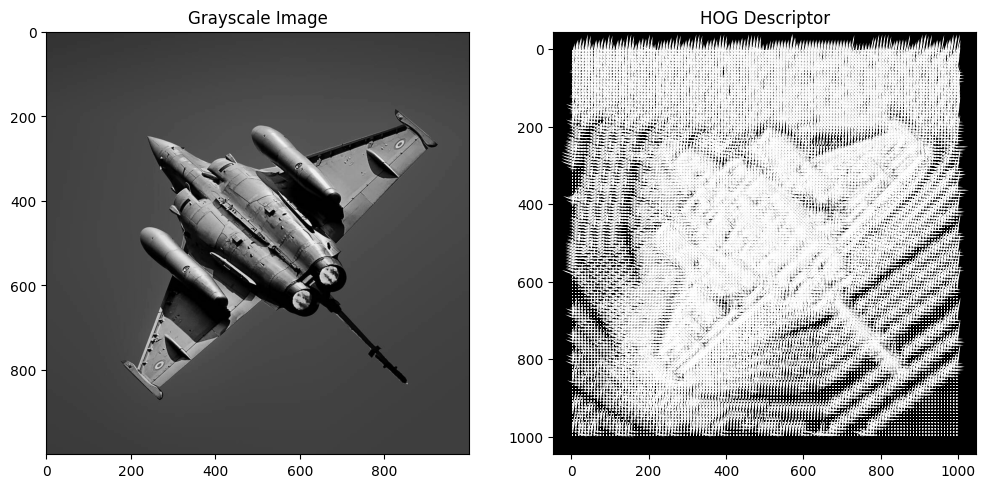

HOG descriptor visualized
HOG features extracted
HOG features reshaped
Average gradients computed
HOG processing completed


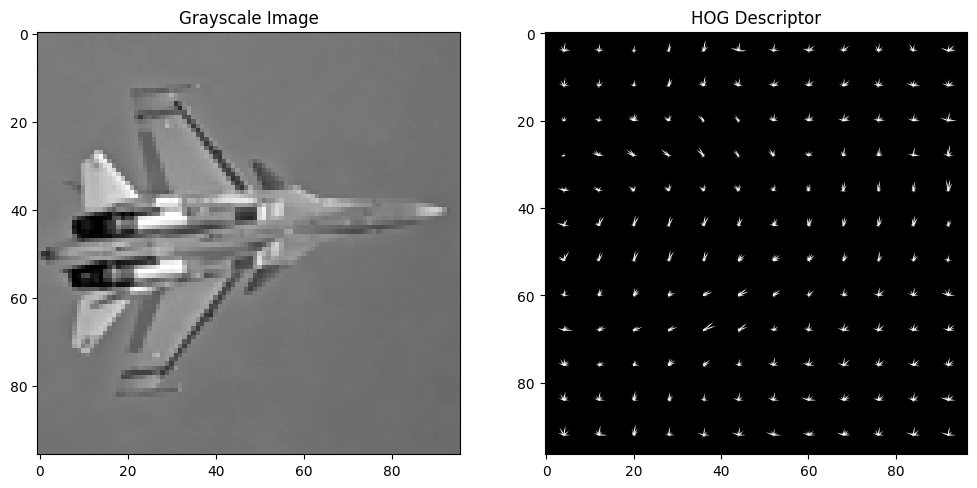

HOG descriptor visualized


In [22]:
def calculate_sobel_gradients(img: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # Compute Sobel gradients along x and y axes
    grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction = np.arctan2(grad_y, grad_x) * (180 / np.pi) % 180
    print(f"Sobel gradients calculated")
    
    return magnitude, direction

def extract_hog_features(img: np.ndarray, cell_dim: tuple = (8, 8), blk_dim: tuple = (16, 16), blk_stride: tuple = (8, 8), bins: int = 9):
    window_dim = img.shape[:2]
    hog_extractor = cv2.HOGDescriptor(window_dim, blk_dim, blk_stride, cell_dim, bins)
    hog_values = hog_extractor.compute(img)

    num_blk_x = (window_dim[1] - blk_dim[0]) // blk_stride[0] + 1
    num_blk_y = (window_dim[0] - blk_dim[1]) // blk_stride[1] + 1
    print(f"HOG features extracted")
    
    return hog_values, num_blk_x, num_blk_y

def reshape_hog_features(hog_vals, num_blk_x, num_blk_y, blk_dim, cell_dim, bins):
    reshaped_hog = hog_vals.reshape(num_blk_y,
                                    num_blk_x,
                                    blk_dim[1] // cell_dim[1],
                                    blk_dim[0] // cell_dim[0],
                                    bins).transpose((1, 0, 2, 3, 4))
    print(f"HOG features reshaped")
    return reshaped_hog

def compute_avg_gradients(hog_reshaped, num_blk_x, num_blk_y, blk_dim, cell_dim, bins):
    #Compute average gradients for each cell in the HOG descriptor.
    avg_grad = np.zeros((num_blk_y + 1, num_blk_x + 1, bins))
    hist_counts = np.zeros((num_blk_y + 1, num_blk_x + 1, 1))

    for i in range(blk_dim[1] // cell_dim[1]):
        for j in range(blk_dim[0] // cell_dim[0]):
            avg_grad[i:num_blk_y + i, j:num_blk_x + j] += hog_reshaped[:, :, i, j, :]
            hist_counts[i:num_blk_y + i, j:num_blk_x + j] += 1

    avg_grad /= hist_counts

    vector_length = avg_grad.shape[0] * avg_grad.shape[1] * avg_grad.shape[2]
    angles = np.linspace(0, np.pi, bins, endpoint=False)

    U = np.zeros((vector_length))
    V = np.zeros((vector_length))
    X = np.zeros((vector_length))
    Y = np.zeros((vector_length))

    count = 0
    for i in range(avg_grad.shape[0]):
        for j in range(avg_grad.shape[1]):
            for k in range(avg_grad.shape[2]):
                U[count] = avg_grad[i, j, k] * np.cos(angles[k])
                V[count] = avg_grad[i, j, k] * np.sin(angles[k])

                X[count] = (cell_dim[0] / 2) + (cell_dim[0] * i)
                Y[count] = (cell_dim[1] / 2) + (cell_dim[1] * j)

                count += 1

    print(f"Average gradients computed")
    return U, V, X, Y

def show_hog_on_image(img: np.ndarray, U, V, X, Y):
    fig, (ax_img, ax_hog) = plt.subplots(1, 2, figsize=(12, 6))

    ax_img.set(title='Grayscale Image')
    ax_img.imshow(img, cmap='gray')

    ax_hog.set(title='HOG Descriptor')
    ax_hog.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0, scale_units='inches', scale=3)
    ax_hog.invert_yaxis()
    ax_hog.set_aspect(aspect=1)
    ax_hog.set_facecolor('black')

    plt.show()
    print(f"HOG descriptor visualized")

def process_hog(img):
    hog_vals, num_blk_x, num_blk_y = extract_hog_features(img)

    hog_reshaped = reshape_hog_features(hog_vals, num_blk_x, num_blk_y, (16, 16), (8, 8), 9)

    U, V, X, Y = compute_avg_gradients(hog_reshaped, num_blk_x, num_blk_y, (16, 16), (8, 8), 9)

    print(f"HOG processing completed")
    return U, V, X, Y


# Test with an image
img_test = load_image(r"C:\Users\Quentin\Documents\Savoir\Sciences\Informatiques\IA\Machine_Learning\Image & Video Processing\TP2\sous-la-voilure-du-rafale.jpg", to_gray=True)
U, V, X, Y = process_hog(img_test)
show_hog_on_image(img_test, U, V, X, Y)

# Another test with a different image
img_sample = load_image(test_img_path, to_gray=True)
U_, V_, X_, Y_ = process_hog(img_sample)
show_hog_on_image(img_sample, U_, V_, X_, Y_)


HOG features extracted
HOG features reshaped
Average gradients computed
HOG processing completed


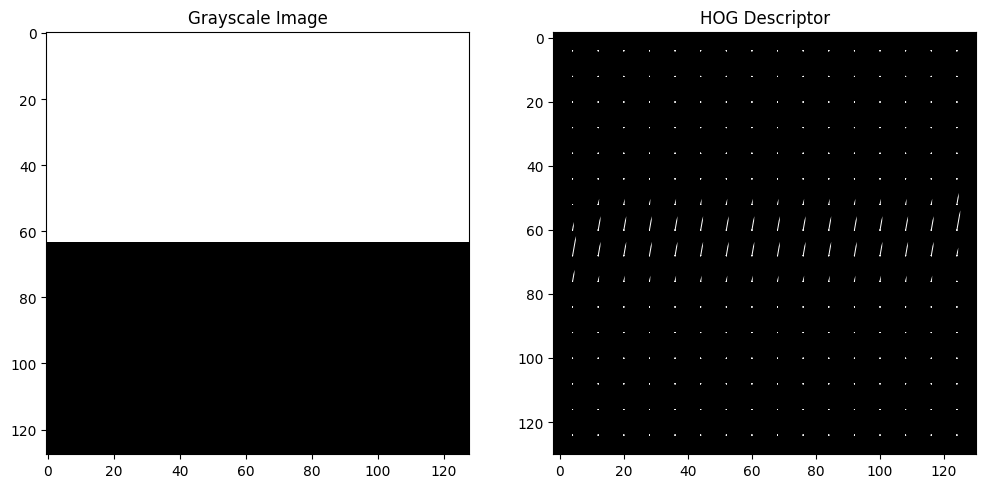

HOG descriptor visualized


In [23]:
def generate_half_black_image(img_width: int, img_height: int) -> np.ndarray:
    img = np.ones((img_height, img_width), dtype=np.uint8) * 255
    img[img_height // 2:, :] = 0

    return img

# Create an image and compute its HOG
half_black_img = generate_half_black_image(128, 128)
U_test, V_test, X_test, Y_test = process_hog(half_black_img)
show_hog_on_image(half_black_img, U_test, V_test, X_test, Y_test)

In [33]:
def focus_hog_cell(image: np.ndarray, cell_x: int, cell_y: int, cell_size: tuple = (8, 8), block_size: tuple = (16, 16), num_bins: int = 9):

    # magnitude and direction
    magnitude, angle = calculate_sobel_gradients(image)

    #Extract the region corresponding to the selected HOG cell
    cell_region = image[cell_y * cell_size[1]:(cell_y + 1) * cell_size[1], cell_x * cell_size[0]:(cell_x + 1) * cell_size[0]]

    # Extract magnitude and angle for the selected cell
    cell_magnitude = magnitude[cell_y * cell_size[1]:(cell_y + 1) * cell_size[1], cell_x * cell_size[0]:(cell_x + 1) * cell_size[0]]
    cell_angle = angle[cell_y * cell_size[1]:(cell_y + 1) * cell_size[1], cell_x * cell_size[0]:(cell_x + 1) * cell_size[0]]

    # Plot grayscale image, zoomed cell, gradients, and histogram
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title("Full Image (Grayscale)")
    rect = plt.Rectangle((cell_x * cell_size[0], cell_y * cell_size[1]), cell_size[0], cell_size[1], edgecolor='red', facecolor='none')
    axes[0, 0].add_patch(rect)

    axes[0, 1].imshow(cell_region, cmap='gray')
    axes[0, 1].set_title("Selected Cell (Zoom)")

    X, Y = np.meshgrid(np.arange(0, cell_size[0]), np.arange(0, cell_size[1]))
    U = cell_magnitude * np.cos(np.deg2rad(cell_angle))
    V = cell_magnitude * np.sin(np.deg2rad(cell_angle))
    axes[1, 0].quiver(X, Y, U, V, color='red')
    axes[1, 0].invert_yaxis()
    axes[1, 0].set_title("Gradients in Selected Cell")

    axes[1, 1].hist(cell_angle.flatten(), bins=num_bins, range=(0, 180), weights=cell_magnitude.flatten(), edgecolor='black')
    axes[1, 1].set_title("Histogram of Gradients")
    axes[1, 1].set_xlabel("Angle (degrees)")
    axes[1, 1].set_ylabel("Weighted Magnitude")

    plt.tight_layout()
    plt.show()


Sobel gradients calculated


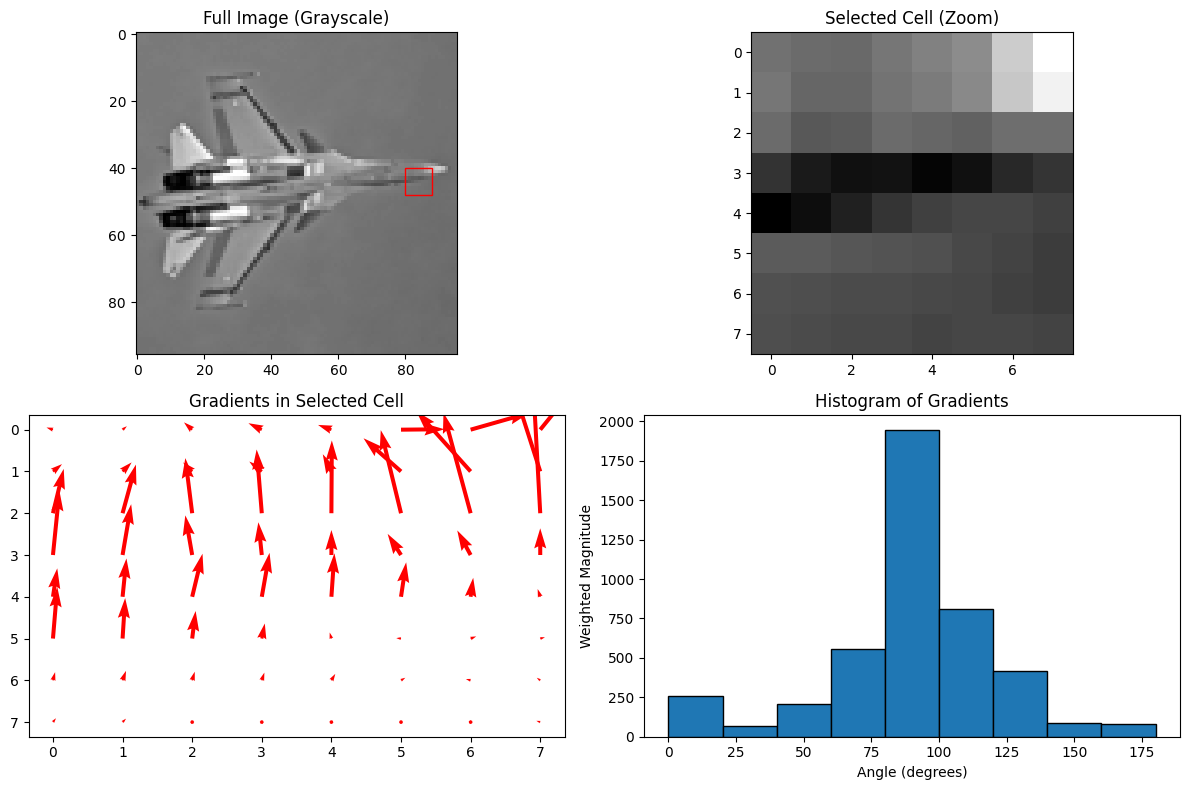

In [35]:
focus_hog_cell(img_sample, 10, 5)

In [39]:
def extract_hog_from_image(image_path: str, folder_name: str):

    try:
        img = read_image(image_path, grey_scale=True)
        hog_data, n_blocks_x, n_blocks_y = compute_hog_descriptor(img)
        return hog_data, folder_name #Extracts the HOG descriptor
    except Exception as err:
        print(f"Error processing {image_path}: {err}")
        return None

def analyze_images_in_directory(dir_path: str, folder_name: str):

    hog_list = []
    for img_file in os.listdir(dir_path):
        img_path = os.path.join(dir_path, img_file)
        if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            hog_result = extract_hog_from_image(img_path, folder_name)
            if hog_result is not None:
                hog_list.append(hog_result) #HOG descriptors for all images in a directory
    return hog_list

def process_all_folders_in_dir(root_dir: str, n_jobs: int = -1):

    # compute HOG descriptors in parallel.
    subdirs = [sub for sub in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, sub))]
    results = Parallel(n_jobs=n_jobs)(
        delayed(analyze_images_in_directory)(os.path.join(root_dir, subdir), subdir)
        for subdir in tqdm(subdirs, desc="Processing Directories")
    )

    return [entry for result_list in results for entry in result_list]


In [41]:
all_hog_descriptors = process_all_folders_in_dir(training_dir, n_jobs=-1)
reduced_hog_descriptors = process_all_folders_in_dir(testing_dir, n_jobs=-1)


Processing Directories: 100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


# 1.4 Visual Vocabulary Construction with K-means Clustering


In [42]:
def initialize_random_centroids(hog_data: np.ndarray, num_clusters: int) -> np.ndarray:

    #Initialize num_clusters random centroids from the data points.
    num_samples = hog_data.shape[0]
    selected_indices = np.random.permutation(num_samples)[:num_clusters]
    random_centroids = hog_data[selected_indices]
    return random_centroids

def assign_data_to_clusters(hog_data: np.ndarray, centroids: np.ndarray) -> np.ndarray:

    #Assign each data point to the nearest centroid based on Euclidean distance
    distance_matrix = cdist(hog_data, centroids, metric='euclidean')
    return np.argmin(distance_matrix, axis=1)

def update_cluster_centroids(hog_data: np.ndarray, cluster_labels: np.ndarray, num_clusters: int) -> np.ndarray:
    new_centroids = np.zeros((num_clusters, hog_data.shape[1]))
    for k in range(num_clusters):
        new_centroids[k] = np.mean(hog_data[cluster_labels == k], axis=0)
    return new_centroids #Update centroids as the mean of all data points assigned to each cluster


def perform_kmeans_clustering(hog_data: np.ndarray, num_clusters: int, max_iterations: int = 100, tolerance: float = 1e-4) -> np.ndarray:

    #Perform K-means clustering on the data.
 
    random_centroids = initialize_random_centroids(hog_data, num_clusters)

    for iteration in range(max_iterations):
        previous_centroids = random_centroids
        cluster_labels = assign_data_to_clusters(hog_data, random_centroids)
        random_centroids = update_cluster_centroids(hog_data, cluster_labels, num_clusters)

        if np.linalg.norm(random_centroids - previous_centroids) < tolerance:
            break

    return random_centroids, cluster_labels

def kmeans_with_ground_truth_labels(hog_data: np.ndarray, results: list, num_clusters: int, max_iterations: int = 100, tolerance: float = 1e-4) -> list:
    #Perform K-means clustering and return the assigned cluster and original type (ground truth).
    random_centroids, cluster_labels = perform_kmeans_clustering(hog_data, num_clusters, max_iterations, tolerance)
    clusters_with_original_type = [(cluster_labels[i], results[i][1]) for i in range(len(cluster_labels))]

    return clusters_with_original_type

def extract_hog_descriptors(results: list) -> np.ndarray:
    #Collect all HOG descriptors from the results.
    descriptors = [descriptor for descriptor, _ in results]
    return np.vstack(descriptors)


def verify_cluster_assignments(cluster_labels: np.ndarray, results: list):
    folder_to_clusters = {}

    for index, (_, parent_folder) in enumerate(results): #Verify if images from the same parent folder are in the same cluster.
        if parent_folder not in folder_to_clusters:
            folder_to_clusters[parent_folder] = set()
        folder_to_clusters[parent_folder].add(cluster_labels[index])

    for parent_folder, clusters in folder_to_clusters.items():
        if len(clusters) > 1:
            print(f"Images from {parent_folder} are in multiple clusters: {clusters}")
        else:
            print(f"All images from {parent_folder} are in the same cluster: {list(clusters)[0]}")

def compute_clustering_accuracy(cluster_labels, true_labels):
    #Calculate the accuracy of the clustering based on true labels
    confusion_mat = confusion_matrix(true_labels, cluster_labels)
    row_indices, col_indices = linear_sum_assignment(-confusion_mat)

    accuracy_score = confusion_mat[row_indices, col_indices].sum() / cluster_labels.size
    return accuracy_score

def associate_clusters_with_parent_folder(cluster_labels, directory_path):
    
    parent_folders = os.listdir(directory_path)
    cluster_to_folder_mapping = {index: folder for index, folder in enumerate(parent_folders)}
    return [cluster_to_folder_mapping[label] for label in cluster_labels] #Map cluster numbers to the most common parent folder (class) within each cluster.


def apply_folder_mapping_to_clusters(cluster_with_original_labels, directory_path):
   
    assigned_clusters = [assigned for assigned, _ in cluster_with_original_labels]
    mapped_clusters = associate_clusters_with_parent_folder(assigned_clusters, directory_path)
    
    return [(mapped_clusters[i], original_type) for i, (_, original_type) in enumerate(cluster_with_original_labels)] #Apply the cluster-to-folder mapping in a single comprehension.

def compute_clustering_accuracy(updated_cluster_with_original_labels):

    #Calculate the accuracy of the clustering based on the assigned clusters and original types.

    assigned_clusters = [assigned for assigned, _ in updated_cluster_with_original_labels]
    original_labels = [original for _, original in updated_cluster_with_original_labels]

    unique_assigned_clusters = list(set(assigned_clusters))
    unique_original_labels = list(set(original_labels))

    assigned_cluster_indices = [unique_assigned_clusters.index(cluster) for cluster in assigned_clusters]
    original_label_indices = [unique_original_labels.index(label) for label in original_labels]

    confusion_mat = confusion_matrix(original_label_indices, assigned_cluster_indices)

    row_indices, col_indices = linear_sum_assignment(-confusion_mat)

    accuracy_score = confusion_mat[row_indices, col_indices].sum() / len(assigned_clusters)

    return accuracy_score

In [ ]:
K = 10  # Number of clusters
results = process_all_folders_in_dir(training_dir, n_jobs=-1)
data = extract_hog_descriptors(results)  # Collecting HOG descriptors from results
cluster_with_original_labels = kmeans_with_ground_truth_labels(data, results, K)  # K-means clustering with ground truth
updated_cluster_with_original_labels = apply_folder_mapping_to_clusters(cluster_with_original_labels, training_dir)  # Map clusters to folder names
accuracy_score = compute_clustering_accuracy(updated_cluster_with_original_labels)  # Calculate clustering accuracy

print(f"Clustering Accuracy: {accuracy_score:.2f}")  # Print the accuracy score


In [102]:
K_reduced_set=2
data_reduced_set = collect_hog_descriptors(result_reduced_set)
cluster_with_original_type_reduced_set = kmeans_with_ground_truth(data_reduced_set, result_reduced_set, K_reduced_set)
updated_cluster_with_original_type_reduced_set = apply_mapping_to_clusters(cluster_with_original_type_reduced_set, testing_dir_dir)
calculate_clustering_accuracy(updated_cluster_with_original_type_reduced_set)

0.888

In [49]:
def plot_cluster_distribution(cluster_and_original_labels, num_clusters: int):
    #Extract assigned clusters and original labels from the input
    assigned_cluster_labels = [cluster for cluster, _ in cluster_and_original_labels]
    original_labels = [label for _, label in cluster_and_original_labels]

    unique_clusters = list(set(assigned_cluster_labels))
    unique_original_labels = list(set(original_labels))

    # Initialize a matrix to count occurrences of cluster
    distribution_matrix = np.zeros((len(unique_clusters), len(unique_original_labels)))

    
    for cluster, original_label in cluster_and_original_labels:#populate the distribution matrix
        cluster_index = unique_clusters.index(cluster)
        label_index = unique_original_labels.index(original_label)
        distribution_matrix[cluster_index, label_index] += 1

    fig, ax = plt.subplots(figsize=(12, 8))

    bottom_values = np.zeros(len(unique_clusters))
    for i, original_label in enumerate(unique_original_labels):
        ax.bar(unique_clusters, distribution_matrix[:, i], label=original_label, bottom=bottom_values)
        bottom_values += distribution_matrix[:, i]

    ax.set_xlabel('Cluster')
    ax.set_ylabel('Numb Images')
    ax.set_title('Distribution of Images Across Clusters according Categories')
    ax.legend(title='Original Label')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
plot_cluster_distribution(updated_cluster_with_original_type, K)


In [ ]:
plot_cluster_distribution(updated_cluster_with_original_type_reduced_set, K_reduced_set)

In [ ]:
def assign_data_points_to_centroids(data: np.ndarray, centroids: np.ndarray) -> np.ndarray: 

    # Calculate Euclidean distances between each data point and the centroids
    distances = cdist(data, centroids, metric='euclidean')  # L2 Norm (Euclidean)
    
    # Assign each data point to the nearest centroid (smallest distance)
    return np.argmin(distances, axis=1)


In [106]:
K_euclidian = 10
data_euclidian = collect_hog_descriptors(results)
cluster_with_original_type_euclidian = kmeans_with_ground_truth(data_euclidian, results, K)
updated_cluster_with_original_type_euclidian = apply_mapping_to_clusters(cluster_with_original_type_euclidian, training_dir)
calculate_clustering_accuracy(updated_cluster_with_original_type_euclidian)

0.25

In [ ]:
plot_cluster_distribution(updated_cluster_with_original_type_euclidian, K)

In [107]:
K_reduced_set_euclidian =2
data_reduced_set_euclidian  = collect_hog_descriptors(result_reduced_set)
cluster_with_original_type_reduced_set_euclidian  = kmeans_with_ground_truth(data_reduced_set_euclidian , result_reduced_set, K_reduced_set)
updated_cluster_with_original_type_reduced_set_euclidian  = apply_mapping_to_clusters(cluster_with_original_type_reduced_set_euclidian , testing_dir)
calculate_clustering_accuracy(updated_cluster_with_original_type_reduced_set_euclidian )

0.891

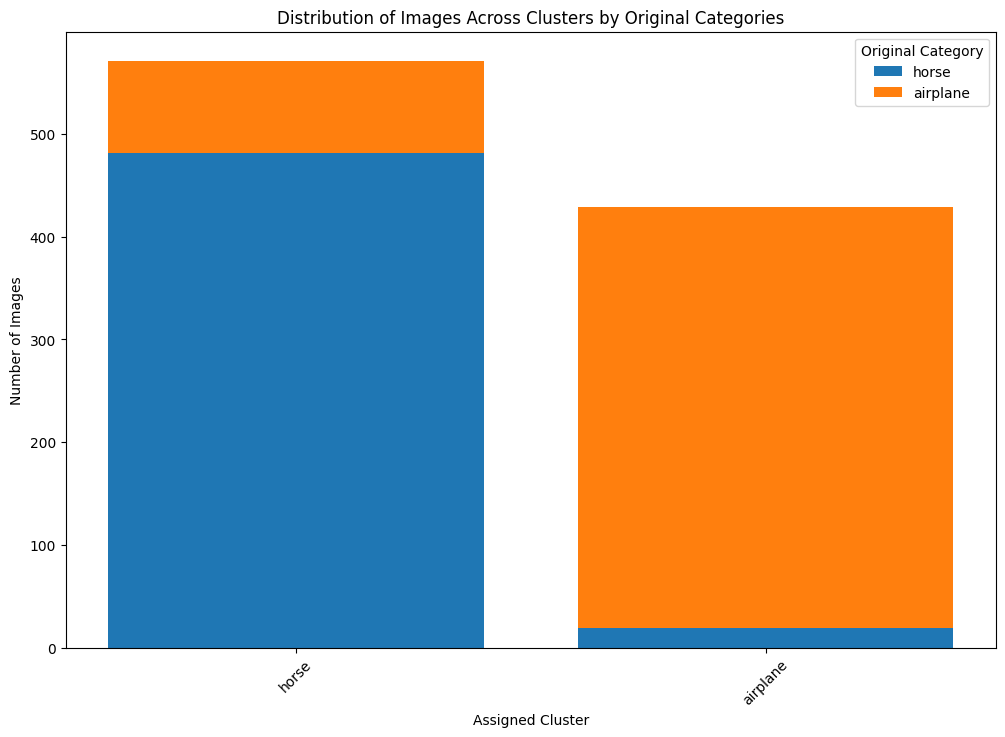

In [109]:
visualize_clplot_cluster_distributionuster_distribution(updated_cluster_with_original_type_reduced_set_euclidian, K)